# TQQQ Demo

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Simulating Leveraged Adjusted Close Prices

The code loads and processes simulated leveraged adjusted close prices for a given equity. Here's a breakdown:
- The function `simulate_data.process_leveraged_data()` downloads historical price data for a specified ticker (e.g., "QQQ") and uses a leverage scalar (e.g., 3x) to determine the multiplier for leveraged returns.
- The function calculates daily percentage returns (`Daily Return`) from the adjusted close prices.
- Leveraged returns are simulated by multiplying the daily returns by the specified leverage scalar.
- These leveraged returns are then compounded to simulate the cumulative leveraged price (`Simulated Leveraged Price`).


In [52]:
# Load in the desired ticker
import simulate_data
data = simulate_data.process_leveraged_data('QQQ', 3)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Leveraged Return,Simulated Leveraged Price
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,43.417267,5232000,NaN,0.000000,43.417267
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,43.629845,9688600,0.004896,0.014688,44.055000
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,42.566975,8743600,-0.024361,-0.073083,40.835318
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,43.789280,6369000,0.028715,0.086145,44.353062
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,44.161274,4905800,0.008495,0.025485,45.483412


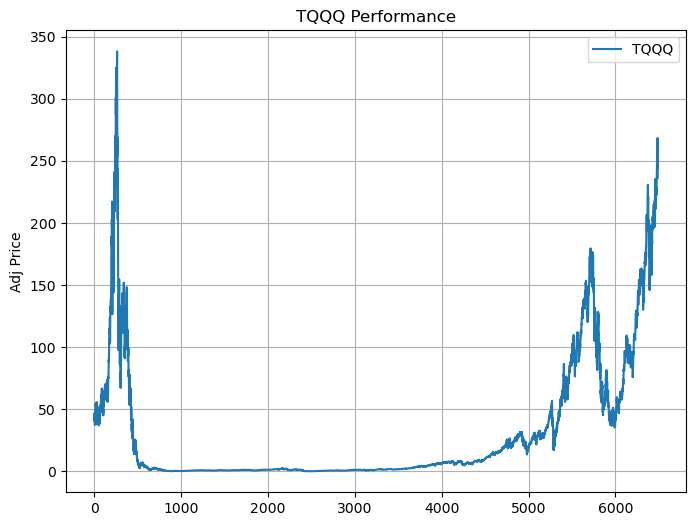

In [53]:
# Graphing the Cumulative returns of the ETF's and splits in question
plt.figure(figsize=(8, 6))
plt.plot(data['Simulated Leveraged Price'], label='TQQQ')
plt.legend()
plt.title('TQQQ Performance')
plt.ylabel('Adj Price')
plt.grid(True)
plt.show()

## Identifying Indices of All-Time Highs

This code identifies the indices where the adjusted close price and the simulated leveraged price reach new all-time highs to be used later in analysis.

In [54]:
# Grab Indices where the 'Adj Close' is the new all time high
ath_indices_baseline = []
current_ath = -9999
for idx, value in data['Adj Close'].items():
    if value > current_ath:
        current_ath = value
        ath_indices_baseline.append(idx)

# Grab Indices where the 'Simulated Leveraged Price' is the new all time high
ath_indices_leveraged  = []
current_ath = -9999
for idx, value in data['Simulated Leveraged Price'].items():
    if value > current_ath:
        current_ath = value
        ath_indices_leveraged .append(idx)

# Add a flag to identify when an ATH occurs
data['ATH_baseline_flag'] = data.index.isin(ath_indices_baseline).astype(int)
data['ATH_leveraged_flag'] = data.index.isin(ath_indices_leveraged).astype(int)

In [55]:
print(len(ath_indices_baseline))
print(len(ath_indices_leveraged))

410
58


## Calculating Returns 

Calculate returns for investments made at all-time highs given a holding period of Z days.
- 3 Months is 91 days
- 6 Months is 182 days
- 12 Months is 365 days
- 24 Months is 730 days

### Calculating Retruns of TQQQ

In [56]:
def calculate_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []
    for idx in ath_indices:
        row = {'ATH_Index': idx, 'Date': data.loc[idx, 'Date']}
        for period_name, holding_period in holding_periods.items():
            if idx + holding_period < len(data):
                entry_price = data['Adj Close'].iloc[idx]
                exit_price = data['Adj Close'].iloc[idx + holding_period]
                return_pct = (exit_price - entry_price) / entry_price
                row[period_name] = return_pct
            else:
                row[period_name] = None  # Handle cases where holding period exceeds data length

        results.append(row)
    return pd.DataFrame(results)

# Usage
ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
print(ath_returns_df.iloc[:,2:].describe())


       Return_3M  Return_6M  Return_12M  Return_24M  Return_48M
count  58.000000  58.000000   58.000000   58.000000   58.000000
mean    0.195079   0.270534   -0.171983   -0.614358   -0.454775
std     0.261241   0.363669    0.476497    0.154785    0.115935
min    -0.234607  -0.416268   -0.712102   -0.789639   -0.641188
25%     0.006912   0.129513   -0.465858   -0.704008   -0.546067
50%     0.128789   0.253783   -0.371220   -0.684782   -0.443924
75%     0.429783   0.506673   -0.029460   -0.542476   -0.391451
max     0.741446   0.987341    0.875153   -0.288910   -0.208439


In [57]:
def calculate_non_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []

    for idx in data.index:
        if idx not in ath_indices:  # Exclude ATH indices
            row = {'Index': idx, 'Date': data.loc[idx, 'Date']}
            for period_name, holding_period in holding_periods.items():
                if idx + holding_period < len(data):  # Ensure holding period is valid
                    entry_price = data['Adj Close'].iloc[idx]
                    exit_price = data['Adj Close'].iloc[idx + holding_period]
                    return_pct = (exit_price - entry_price) / entry_price
                    row[period_name] = return_pct
                else:
                    row[period_name] = None  # Handle cases where holding period exceeds data length
            
            results.append(row)
    return pd.DataFrame(results)

# Usage
non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)
print(non_ath_returns_df.iloc[:, 2:].describe())


         Return_3M    Return_6M   Return_12M   Return_24M   Return_48M
count  6339.000000  6248.000000  6065.000000  5700.000000  4970.000000
mean      0.044471     0.093194     0.181052     0.392305     1.088822
std       0.147517     0.227730     0.317636     0.433593     0.852545
min      -0.511828    -0.661615    -0.721461    -0.792052    -0.642365
25%      -0.015083    -0.004254     0.048207     0.177967     0.402658
50%       0.063113     0.123248     0.207932     0.470783     1.275529
75%       0.121583     0.215950     0.395621     0.668615     1.703657
max       0.811705     1.153940     1.246033     1.818127     3.334744


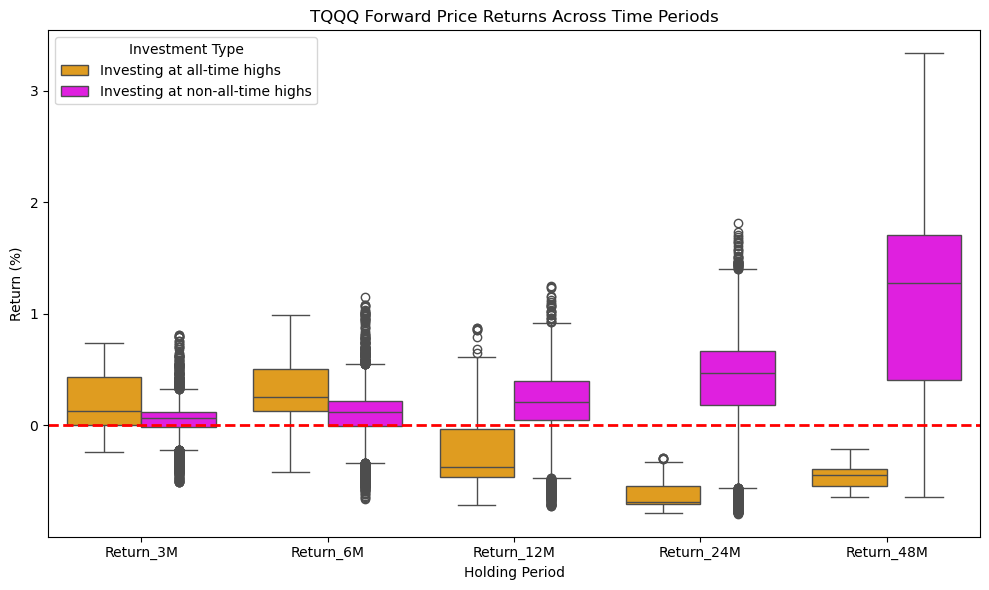

In [58]:
# Add group flag
ath_returns_df['Group'] = 'Investing at all-time highs'
non_ath_returns_df['Group'] = 'Investing at non-all-time highs'
# Join the two df's
combined_df = pd.concat([ath_returns_df, non_ath_returns_df])

# Melt DataFrame for the two groups & their holding periods
melted_df = combined_df.melt(
    id_vars=['Group'], 
    value_vars=['Return_3M', 'Return_6M', 'Return_12M', 'Return_24M', 'Return_48M'], 
    var_name='Holding Period', 
    value_name='Return'
)

# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=melted_df, 
    x='Holding Period', 
    y='Return', 
    hue='Group', 
    palette=['orange', 'magenta']
)

plt.title('TQQQ Forward Price Returns Across Time Periods')
plt.xlabel('Holding Period')
plt.ylabel('Return (%)')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a baseline for 0% return
plt.legend(title='Investment Type')
plt.tight_layout()
plt.show()
